In [1]:
import os, sys
import tensorflow as tf
import numpy as np
import time
import csv
import random
import subprocess
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import keras
from keras.layers import Flatten, Input, Dense
from keras.layers import Dropout, Conv1D, Activation, MaxPooling1D
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from sklearn.metrics import classification_report
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import roc_curve
from keras import backend as K
from tensorflow import set_random_seed


Using TensorFlow backend.


In [2]:
#load datasets
def get_datasets(diseases, nr_inputs=260):
    datasets = []
    sample_dir = "datasets/samples"
    for idx, disease in enumerate(diseases):
        dataset_dir = os.path.join(sample_dir, str(idx))
        datasets.append([])
        for record in sorted(os.listdir(dataset_dir)):
            record_path = os.path.join(dataset_dir, record)
            with open(record_path) as dis:
                dataset = np.loadtxt(dis)
                if len(dataset) != nr_inputs:
                    print(len(dataset), nr_inputs)
                    continue
                datasets[idx].append(dataset)
    return datasets

In [3]:
def normalize_data(datasets):
    normalized=[]
    for case in datasets:
        cases=[]
        for data in case:
            mu = np.mean(data)
            sigma = np.std(data)
            #fixed = (np.array(data) - mu) / sigma
            fixed = stats.zscore(data)
            cases.append(fixed)
        normalized.append(cases) 
    return normalized

In [4]:
def generate_data(data):
    s_thd = np.random.uniform(low=0.10, high=0.18, size=None)
    m_thd = np.random.uniform(low=-0.2, high=0.2, size=None)
    mu, sigma = np.mean(data), np.std(data)
    noise = np.random.normal(mu, sigma, [data.shape[0],]) * s_thd + m_thd
    fixed = data + noise
    return fixed

In [5]:
def generate_datasets(datasets, data_length):
    generate_data_num = [max(data_length) - x for x in data_length]
    for idx, num in enumerate(generate_data_num):
        for i in range(num):
            target_idx = np.random.randint(data_length[idx], size=None)
            target_data = datasets[idx][target_idx]
            datasets[idx].append(generate_data(target_data).tolist())
    return datasets

In [6]:
def split_train_valid(datasets, split=0.9):
    data_length = [len(x) for x in datasets]
    train_length = int(min(data_length) * split)
    train_data = [x[:train_length] for x in datasets]
    valid_data = [x[train_length:] for x in datasets]
    return train_data, valid_data

In [7]:
def get_label(data):
    label= [[idx]*len(x) for idx, x in enumerate(data)]
    label= label[0]+label[1]+label[2]+label[3]+label[4]
    return label

In [8]:
def get_cnn_model(filter_num,filter_size, num_classes=5, 
                  activation='relu', maxpool_size=2, dim=260):
    
    cnn_model = Sequential()
    cnn_model.add(Conv1D (kernel_size=filter_size,
                          filters=filter_num, 
                          input_shape=(dim,1)))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation(activation))
    cnn_model.add(MaxPooling1D(pool_size=(maxpool_size)))
    
    cnn_model.add(Conv1D(kernel_size=filter_size,
                         filters=filter_num))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation(activation))
    cnn_model.add(MaxPooling1D(pool_size=(maxpool_size)))
    
    cnn_model.add(Conv1D(kernel_size=filter_size,
                         filters=filter_num))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation(activation))
    cnn_model.add(MaxPooling1D(pool_size=(maxpool_size)))
    
    cnn_model.add(Conv1D(kernel_size=filter_size,
                         filters=filter_num))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation(activation))
    cnn_model.add(MaxPooling1D(pool_size=(maxpool_size)))
    
    cnn_model.add(Flatten())
    cnn_model.add(Dense(30))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation(activation))
    cnn_model.add(Dense(20))
    cnn_model.add(Activation(activation))
    cnn_model.add(Dense(num_classes))
    cnn_model.add(Activation('softmax'))
    return cnn_model

In [9]:
def fit_model(model, x_train, y_train, x_test, y_test, opt, 
             batch_size=128, epochs=30, shuffle=True,
             loss='categorical_crossentropy',
             metrics=['accuracy'], verbose=0):
    
    model.compile(loss=loss, optimizer=opt, metrics=metrics)
    history = model.fit(x_train, y_train, 
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        shuffle=shuffle,
                       verbose=verbose)
    return history

In [10]:
def get_predict_numpy(model, datasets):
    rs = model.predict(datasets)
    return rs

In [11]:
def get_total_num(y_true, y_pred, label_num):
    total_nums=[]
    for a in range(label_num):
        nums=[]
        idx = np.array(y_true)==a
        for case in range(label_num):
            nums.append(sum(np.array(y_pred)[idx]==case))
        total_nums.append(nums)
    return total_nums

In [12]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [13]:
np.random.seed(0)#np
set_random_seed(2)#tf
heart_diseases = ['N', 'S', 'V', 'F', 'Q']
num_classes=5

In [14]:
datasets = get_datasets(heart_diseases)
datasets = normalize_data(datasets)
#datasets = [x[:10000] for x in datasets]
data_length = [len(x) for x in datasets]
datasets = generate_datasets(datasets, data_length)
generated_data_length = [len(x) for x in datasets]

In [15]:
train_data = datasets
train_label = get_label(train_data)
train_data = [x for case in train_data for x in case]
train_data = np.reshape(train_data, (len(train_data), 260, 1))

In [16]:
x_train, x_test, y_train, y_test = train_test_split(train_data, 
                                                    train_label,
                                                    train_size=0.8)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [17]:
valid_data = datasets
valid_label = get_label(valid_data)
valid_label = keras.utils.to_categorical(valid_label, num_classes)

In [43]:
#test case of filter size
filter_size=[4,8,16]
#filter_size=[4,12]


#test case of filter num
filter_num=[4,8,12,16]
#filter_num=[32]


#test epochs
epochs=30
#learning rate
lr=0.005
#optimizer
opt = keras.optimizers.Adam(lr=lr)
#batch-size
batch_size = 2048#fix value if appear memory error

#history
rs_history=[]
#model
rs_model=[]
#pred
rs_pred=[]
#report
rs_report=[]

for size in filter_size:
    for num in filter_num:
        print("======================================================")
        
        with K.tensorflow_backend.tf.device('/gpu:0'):
            ##############################
            #get cnn model
            model = get_cnn_model(filter_num=num ,filter_size=size)
            print('[filter num]{}  [filter size]{}'.format(num,size))
            print("------------------------------------------------------")

            ##############################
            #compile and fit model
            print(">>fitting model..")
            
            history = fit_model(model=model, 
                                x_train=x_train,
                                y_train=y_train,
                                x_test=x_test,
                                y_test=y_test,
                                opt=opt,
                                epochs=epochs,
                                verbose=0,
                                batch_size=batch_size
                                )
            
        print(">>fitting complete")
            
        ##############################
        #predict label
        print(">>predict model..")
        predict_list = get_predict_numpy(model, x_test)
        print(">>predict complete")
        
        ##############################
        #data evaluation score
        #label/list | precision | recall | f1-score | support
        #       0 |       
        #       1 |
        #       2 |               score                 num
        #       3 |
        #       4 |  
        print()
        print("[scores]")
        
        flatten_true=[np.argmax(x) for x in y_test]
        flatten_predict=[np.argmax(x) for x in predict_list]
        
        report = classification_report(flatten_true, 
                                    flatten_predict,
                                    target_names=heart_diseases, 
                                    digits=4,
                                    output_dict=True)
        
        ##############################
        #print
        ##############################
        print('(micro-avg)')
        print(report['micro avg'])
        
        ##############################
        #label/pred | 0 | 1 | 2 | 3 | 4 |
        #  0 |                          => sum()=datasets num
        #  1 |                          => sum()=datasets num
        #  2 |         data num         => sum()=datasets num
        #  3 |                          => sum()=datasets num
        #  4 |                          => sum()=datasets num
        ##############################
        r_nums = get_total_num(y_true=flatten_true,
                              y_pred=flatten_predict,
                              label_num=len(heart_diseases))
        print()
        print('[row:label | col:prediction]')
        for r in r_nums:
            print(r)
        

        
        ##############################
        #save result
        ##############################
        print()
        print('[save result]')
        rs_history.append(history)
        rs_model.append(model)
        rs_pred.append(flatten_predict)
        rs_report.append(report)
        
        
        print("======================================================")
        print("\n")

[filter num]4  [filter size]4
------------------------------------------------------
>>fitting model..
>>fitting complete
>>predict model..
>>predict complete

[scores]
(micro-avg)
{'precision': 0.9767, 'recall': 0.9767, 'support': 10000, 'f1-score': 0.9767}

[row:label | col:prediction]
[1921, 41, 17, 6, 7]
[5, 1997, 8, 13, 2]
[10, 17, 1975, 48, 3]
[1, 4, 27, 1902, 4]
[5, 5, 4, 6, 1972]

[save result]


[filter num]8  [filter size]4
------------------------------------------------------
>>fitting model..
>>fitting complete
>>predict model..
>>predict complete

[scores]
(micro-avg)
{'precision': 0.9866, 'recall': 0.9866, 'support': 10000, 'f1-score': 0.9866}

[row:label | col:prediction]
[1971, 9, 5, 2, 5]
[8, 2004, 9, 2, 2]
[10, 14, 2008, 19, 2]
[3, 3, 32, 1897, 3]
[3, 2, 1, 0, 1986]

[save result]


[filter num]12  [filter size]4
------------------------------------------------------
>>fitting model..
>>fitting complete
>>predict model..
>>predict complete

[scores]
(micro-avg)
{'pre

[acc][size : 4][num : 4]:0.9882500000953675
[acc][size : 4][num : 8]:0.9956999994277954
[acc][size : 4][num : 12]:0.9981249995231628
[acc][size : 4][num : 16]:0.9982750003814698


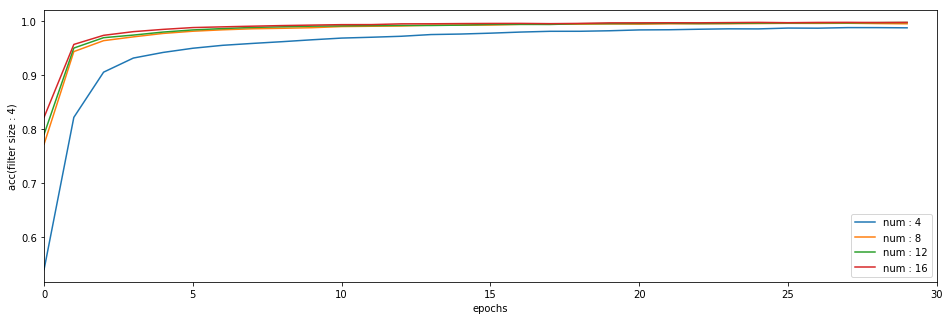

[acc][size : 8][num : 4]:0.9896000001907349
[acc][size : 8][num : 8]:0.9967000007629394
[acc][size : 8][num : 12]:0.9969999995231629
[acc][size : 8][num : 16]:0.99845


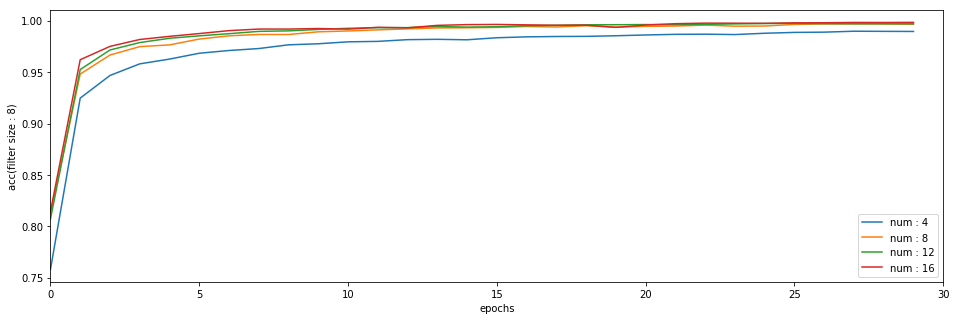

[acc][size : 16][num : 4]:0.976225000667572
[acc][size : 16][num : 8]:0.9942999994277955
[acc][size : 16][num : 12]:0.996975000667572
[acc][size : 16][num : 16]:0.9973250003814698


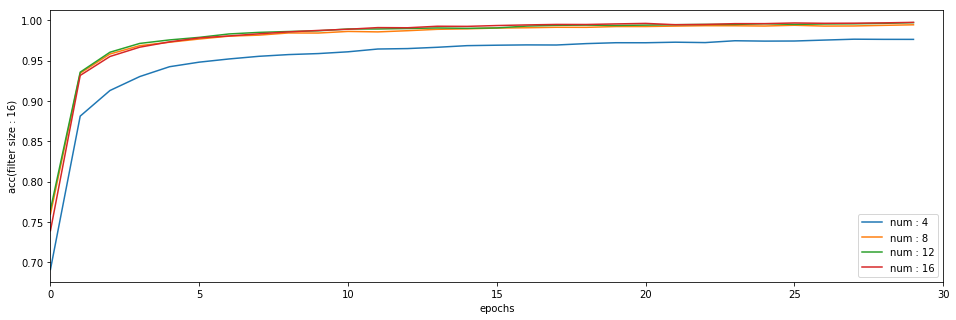

In [44]:
#acc graph 
#graph with each filter size to compare with filter num
for size in range(len(filter_size)):
    plt.figure(figsize=(16,5))
    for num in range(len(filter_num)):
        plt.plot(rs_history[size*len(filter_num)+num].history['acc'], 
                 label="num : {}".format(filter_num[num]))
        plt.xlim((0, epochs))
        plt.legend()
        plt.xlabel('epochs')
        plt.ylabel('acc(filter size : {})'.format(filter_size[size]))
        print('[acc][size : {}][num : {}]:{}'.format(
            filter_size[size],
            filter_num[num],
            rs_history[size*len(filter_num)+num].history['acc'][-1] ))
    plt.show()

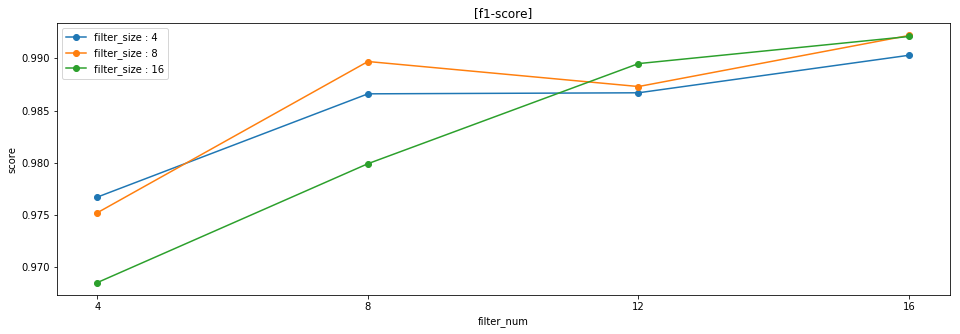

In [45]:
#recall(sen), precision(ppv), f1-score
#graph with each filter size to compare with filter num
legend = ['filter_size : {}'.format(x) for x in filter_size]
#for colkey in ['recall', 'precision', 'f1-score']:
for colkey in ['f1-score']:
    plt.figure(figsize=(16,5))
    for size in range(len(filter_size)):  
        y = []
        plt.title("[{}]".format(colkey))
        plt.xlabel('filter_num')
        plt.ylabel('score') 
        for num in range(len(filter_num)):
            #macro avg : average
            #micro avg : weighted average
            y.append(rs_report[size*len(filter_num)+num]['micro avg'][colkey])
        plt.plot([str(x) for x in filter_num],y,'o-')
    plt.legend(legend)
    plt.show()

In [97]:
#print score values
idx=0
f1_score_mean = [0.] * len(rs_model)
sen_score_mean = [0.] * len(rs_model)
ppv_score_mean = [0.] * len(rs_model)

print_cols = ['support', 'recall', 'precision', 'f1-score']
for size in filter_size:
    for num in filter_num:
        print("[*]size : {}  /  num : {}".format(size, num))
        data = rs_report[idx]
        print("{0:<5}".format(""), end='')
        for col in print_cols:
             print("{0:<17}".format(col), end='')
        print()
        print("----------------------------------------------------------------")
        for key in heart_diseases:
            print("{0:<5}".format(key), end='')
            for val in print_cols:
                print("{0:<15.4f}".format(round(data[key][val],4)), 
                                                         end='  ')
            print()
            f1_score_mean[idx] += data[key]['f1-score']
            sen_score_mean[idx] += data[key]['recall']
            ppv_score_mean[idx] += data[key]['precision']
        print("\n")
        idx+=1

[*]size : 4  /  num : 4
     support          recall           precision        f1-score         
----------------------------------------------------------------
N    1992.0000        0.9644           0.9892           0.9766           
S    2025.0000        0.9862           0.9675           0.9768           
V    2053.0000        0.9620           0.9724           0.9672           
F    1938.0000        0.9814           0.9630           0.9721           
Q    1992.0000        0.9900           0.9920           0.9910           


[*]size : 4  /  num : 8
     support          recall           precision        f1-score         
----------------------------------------------------------------
N    1992.0000        0.9895           0.9880           0.9887           
S    2025.0000        0.9896           0.9862           0.9879           
V    2053.0000        0.9781           0.9771           0.9776           
F    1938.0000        0.9788           0.9880           0.9834           
Q    1

### plot multi classification roc curve

https://hackernoon.com/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a
https://datascienceschool.net/view-notebook/731e0d2ef52c41c686ba53dcaf346f32/


### calulate acc, spec ..

https://datascienceschool.net/view-notebook/731e0d2ef52c41c686ba53dcaf346f32/

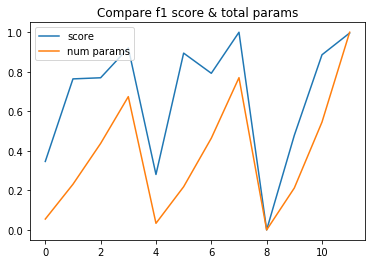

[*]Order by f1 score(Model Index):
[ 7 11  3  5 10  6  2  1  9  0  4  8]
[*]Order by model params(Mdel Index):
[11  7  3 10  6  2  1  5  9  0  4  8]


In [110]:
def normal(data):
    maxval = max(data)
    minval = min(data)
    data = [(x-minval)/(maxval-minval) for x in data]
    return data

model_params = [model.count_params() for model in rs_model]
plt.title('Compare f1 score & total params')
plt.plot(normal(f1_score_mean), label='score')
plt.plot(normal(model_params), label='num params')
plt.legend()
plt.show()


sorted_f1_score = np.argsort(f1_score_mean)[::-1]
print("[*]Order by f1 score(Model Index):\n{}".format(sorted_f1_score))
sorted_params = np.argsort(model_params)[::-1]
print("[*]Order by model params(Mdel Index):\n{}".format(sorted_params))

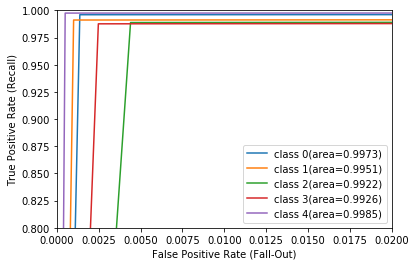

In [107]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

#test model
idx=sorted_f1_score[0]
# Plot linewidth.
lw = 2
#get label
tty = np.array(y_test)
ttp = np.array(rs_pred[idx])

n_values = np.max(ttp) + 1
y_score =  np.eye(n_values)[ttp]

#plot roc curve
n_classes=len(heart_diseases)
fpr = [None] * len(heart_diseases)
tpr = [None] * len(heart_diseases)
thr = [None] * len(heart_diseases)
roc_auc=[None] * len(heart_diseases)

#endx=1.0
#endy=1.0
endx=0.02#zoom
starty=0.80#zoom

###plot roc 0 ~ 1 range
for i in range(len(heart_diseases)):
    fpr[i], tpr[i], thr[i] = roc_curve(tty[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], 
             label="class {}(area={})".format(i,round(roc_auc[i],4)))
    
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim(0.0,endx)
plt.ylim(starty,1.0)
plt.legend()
plt.show()

# Result

1. 1st important thing total number of params
2. 2nd important thing is number of kernels
3. 3rd important thing is balance between number of kernels of size of kernels